In [ ]:
#Install numpy 
#1. sudo apt-get install python3-numpy
#Install matplotlib
#2. sudo pip3 install python3-matplotlib

In [73]:
import csv
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from pyspark import SparkContext
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import NaiveBayes
from pyspark.mllib.regression import LabeledPoint
from pyspark import SparkContext
from pyspark.mllib.feature import HashingTF, IDF
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from nltk.corpus import stopwords

def clean_Tweets(tweetString):
  pattern = r'(.)\1{2,}'
  replacement= r'\1\1'
  tweetString=tweetString.lower()
  tweetString=tweetString.replace("www.","URL")
  tweetString=tweetString.replace("http://","URL")
  tweetString=tweetString.replace("https://","URL")
  tweetString=tweetString.replace("#","")
  tweetString=tweetString.replace("@","AT_USER")
  #Removing the punctuation  
  tweetString=tweetString.strip("!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~")   
  #Removing the stop words
  cleanedTweetString=""
  stop_words_list = stopwords.words('english')
  tweet_list=tweetString.split()
  #Excluding the stop words in the final list
  no_stop_words_list=([i for i in tweet_list if i not in stop_words_list])
  for tweet_word in no_stop_words_list:
    # Check if a tweet word starts only with a alphabhet
    if re.match("^[a-zA-Z]+.*", tweet_word):
        #Replace characters that repeat more than twice (excitedddd to excitedd)
        tweet_word=re.sub(pattern, replacement, tweet_word, flags=re.DOTALL)
        cleanedTweetString+=tweet_word+" "        
  #Perform stemming of each word in the list     
  to_be_stemmed_list=cleanedTweetString.split()
  STEMMER = PorterStemmer()
  stemmed_list = [STEMMER.stem(word) for word in to_be_stemmed_list]
  cleanedTweetString=' '.join(stemmed_list)
  return cleanedTweetString

def featureExtractor(line): 
  words = line.split(",")
  lab=words[0] 
  tweets=words[5].split()
  cleaned_tweets=clean_Tweets(words[5])
  htf = HashingTF(60000)
  return (LabeledPoint(lab.strip('"'),htf.transform(cleaned_tweets.split())),words[5])   


In [74]:
from pyspark import SparkContext
if __name__ == "__main__":
     
    # Load documents (one per line).  
    train_hashed= sc.textFile("data/train.csv").map(featureExtractor)
    train_hashed.persist()

    test_hashed=sc.textFile("data/test.csv").map(featureExtractor)
    test_hashed.persist()  
    #startTweetSentimentClassification()
    

In [75]:
    #Code to compute train accuracy of naive Bayes Model
    def computeNBTrainAccuracy():    
        NBModel = NaiveBayes.train(train_hashed.map(lambda X:X[0]))
        prediction_and_labels_nb_train = train_hashed.map(lambda point: (float(NBModel.predict(point[0].features)), point[0].label))
        correct = prediction_and_labels_nb_train.filter(lambda predicted: predicted[0] == predicted[1])
        accuracy_nb_train = 1.0 * correct.count() / (train_hashed.count())  

        return accuracy_nb_train
    
    

In [76]:
    # Compute train accuracy Logistic Regression Model
    def computeLOGTrainAccuracy():
        LogisticModel = LogisticRegressionWithLBFGS.train(train_hashed.map(lambda X:X[0]))
        prediction_and_labels_lr_train = train_hashed.map(lambda point: (float(LogisticModel.predict(point[0].features)), point[0].label))
        correct = prediction_and_labels_lr_train.filter(lambda predicted: predicted[0] == predicted[1])
        accuracy_lr_train= 1.0 * correct.count() / (train_hashed.count())  
        return accuracy_lr_train
    
  

In [77]:
    #Code to compute test accuracy of Naive Bayes Model
    def computeNBTestAccuracy():
        NBModel = NaiveBayes.train(train_hashed.map(lambda X:X[0]))
        prediction_and_labels_nb_test = test_hashed.map(lambda point: (float(NBModel.predict(point[0].features)), point[0].label))
        correct = prediction_and_labels_nb_test.filter(lambda predicted: predicted[0] == predicted[1])
        accuracy_nb_test = 1.0 * correct.count() / (test_hashed.count())  
        return accuracy_nb_test
    


In [78]:
    #Code to compute test accuracy of Logistic Regression Model
    def computeLOGTestAccuracy():
        LogisticModel = LogisticRegressionWithLBFGS.train(train_hashed.map(lambda X:X[0]))
        prediction_and_labels_lr_test = test_hashed.map(lambda point: (float(LogisticModel.predict(point[0].features)), point[0].label))
        correct = prediction_and_labels_lr_test.filter(lambda predicted: predicted[0] == predicted[1])
        accuracy_lr_test = 1.0 * correct.count() / (test_hashed.count()) 
        return accuracy_lr_test
    
    

In [79]:
    ## 10 fold cross validation for naive Bayes
    def crossValidationNB():
        #Initialize a empty RDD
        test_rdd= sc.emptyRDD()
        train_rdd= sc.emptyRDD()
        NBModelList=[]
        RDD_List=[] #list of RDD obtained after split
        #Randomize and split the training moel into 10 equal parts 
        RDD_List = train_hashed.randomSplit([0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1], seed=0)
        maxAccuracy=0.0
        maxAccuracyIndex=-1
        sumAccuracy=0.0

        for i in range(0,len(RDD_List)):
            test_rdd=RDD_List[i]
            for j in range(0,len(RDD_List)):
                if i!=j:
                    train_rdd=train_rdd+RDD_List[j]

            NBModel = NaiveBayes.train(train_rdd.map(lambda X:X[0]))
            NBModelList.append(NBModel)

            prediction_and_labels = test_rdd.map(lambda point: (NBModel.predict(point[0].features), point[0].label))
            correct = prediction_and_labels.filter(lambda predicted: predicted[0] == predicted[1])
            accuracy = 1.0 * correct.count() / (test_rdd.count()) 
            sumAccuracy+=accuracy
            if accuracy > maxAccuracy:
                maxAccuracy=accuracy
                maxAccuracyIndex=i
            print("Naive Bayes Classifier 10 fold cross validation accuracy for fold "
                  +str(i+1)+" is :" + str(accuracy * 100)+" %")
            test_rdd=sc.emptyRDD()
            train_rdd=sc.emptyRDD()

        avgAccuracyNB=sumAccuracy/10.0   
        print("Average Accuracy for 10 fold="+str(avgAccuracyNB))
        print("Maximum Accuracy is observed for fold "+str(maxAccuracyIndex))
        NBModelList[maxAccuracyIndex].save(sc, "Best_NBModel")
        return maxAccuracy
    
 
   

In [80]:
    #Code to compute test accuracy of saved Best Naive Bayes Model
    def computeBestNBTestAccuracy():
        from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
        Best_NBModel = NaiveBayesModel.load(sc, "Best_NBModel")
        prediction_and_labels_nb_best = test_hashed.map(lambda point: (float(Best_NBModel.predict(point[0].features)), point[0].label))
        correct = prediction_and_labels_nb_best.filter(lambda predicted: predicted[0] == predicted[1])
        accuracy_nb = 1.0 * correct.count() / (test_hashed.count())  
        return accuracy_nb


In [81]:
    #Code to compute precision, recall and f1score of Best NB Model
    
    def printNB_Precision_Recall_F1():
        from pyspark.mllib.evaluation import MulticlassMetrics
        from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
        Best_NBModel = NaiveBayesModel.load(sc, "Best_NBModel")
        prediction_and_labels_nb_best = test_hashed.map(lambda point: (float(Best_NBModel.predict(point[0].features)), point[0].label))
 

        metrics_nb = MulticlassMetrics(prediction_and_labels_nb_best)
        # Overall statistics by label
        precision_0 = metrics_nb.precision(0)
        recall_0 = metrics_nb.recall(0)
        f1Score_0 = metrics_nb.fMeasure(0.0,0.0)   
        print("Best Naive Bayes Model: For Label 0: Precision=%f, Recall=%f, and f1Measure=%f " % (precision_0, recall_0, f1Score_0))

        # Overall statistics by label
        precision_1 = metrics_nb.precision(1)
        recall_1 = metrics_nb.recall(1)
        f1Score_1 = metrics_nb.fMeasure(0.0,1.0)   
        print("Best Naive Bayes Model: For Label 1: Precision=%f, Recall=%f, and f1Measure=%f " % (precision_1, recall_1, f1Score_1))

        #Average Precision, reccall and f1 measure
        precision_avg=(precision_0+precision_1)/2
        recall_avg=(recall_0+recall_1)/2
        f1Score_avg=(f1Score_0+f1Score_1)/2
        print("Best Naive Bayes Model: Average Precision=%f, Recall=%f, and f1Measure=%f " % (precision_avg, recall_avg, f1Score_avg))

        #Confusion Matrix
        print(" Confusion matrix for Best Naive Bayes model:")
        print(metrics_nb.confusionMatrix().toArray()) 

In [82]:
    from pyspark.mllib.evaluation import BinaryClassificationMetrics    
    from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
    def printNBAreaUnderCurve():
        Best_NBModel = NaiveBayesModel.load(sc, "Best_NBModel")
        prediction_and_labels_nb_best = test_hashed.map(lambda point: (float(Best_NBModel.predict(point[0].features)), point[0].label))

        # Printing Results
        metrics = BinaryClassificationMetrics(prediction_and_labels_nb_best)
        # Area under ROC curve
        return( metrics.areaUnderROC)
    
  

In [83]:
    ## 10 fold cross validation for Logistic regression
    def crossValidationLOG():    
        #Initialize a empty RDD
        test_rdd= sc.emptyRDD()
        train_rdd= sc.emptyRDD()
        LOGModelList=[]
        RDD_List=[]#list of RDD obtained after split
         #Randomize and split the training moel into 10 equal parts 
        RDD_List = train_hashed.randomSplit([0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1], seed=0)
        maxAccuracy=0.0
        maxAccuracyIndex=-1
        sumAccuracy=0.0
        for i in range(0,len(RDD_List)):
            test_rdd=RDD_List[i]
            for j in range(0,len(RDD_List)):
                if i!=j:
                    train_rdd=train_rdd+RDD_List[j]

            LogisticModel = LogisticRegressionWithLBFGS.train(train_rdd.map(lambda X:X[0]))
            LOGModelList.append(LogisticModel)
            prediction_and_labels = test_rdd.map(lambda point: (LogisticModel.predict(point[0].features), point[0].label))
            correct = prediction_and_labels.filter(lambda predicted: predicted[0] == predicted[1])
            accuracy = 1.0 * correct.count() / (test_rdd.count())  
            sumAccuracy+=accuracy
            if accuracy > maxAccuracy:
                maxAccuracy=accuracy
                maxAccuracyIndex=i

            print("Logistic regression Classifier 10 fold cross validation accuracy for fold "
                  +str(i+1)+" is :" + str(accuracy * 100)+" %")

            test_rdd=sc.emptyRDD()
            train_rdd=sc.emptyRDD()

        avgAccuracyLOG=sumAccuracy/10.0 
        print("Average Accuracy for 10 fold="+str(avgAccuracyLOG))
        print("Maximum Accuracy is observed for fold "+str(maxAccuracyIndex))

        #removeSavedModels()#remove saved models
        LOGModelList[maxAccuracyIndex].save(sc, "Best_LOGModel")
        return maxAccuracy
    
    crossValidationLOG()

Logistic regression Classifier 10 fold cross validation accuracy for fold 1 is :66.70810542018896 %


KeyboardInterrupt: 

In [85]:
    #Code to compute test accuracy of saved Best Logistic  Model
    
    def computeBestLOGTestAccuracy():
        from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
        Best_LOGModel = LogisticRegressionModel.load(sc, "Best_LOGModel")
        prediction_and_labels_lr_best = test_hashed.map(lambda point: (float(Best_LOGModel.predict(point[0].features)), point[0].label))
        correct = prediction_and_labels_lr_best.filter(lambda predicted: predicted[0] == predicted[1])
        accuracy_lr = 1.0 * correct.count() / (test_hashed.count())
        return accuracy_lr
    

    

In [95]:
    #Code to compute precision, recall, f1score and confusion matrix  of Best LOG Model 
    
    def printLOG_Precision_Recall_F1():
        from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
        Best_LOGModel = LogisticRegressionModel.load(sc, "Best_LOGModel")
        prediction_and_labels_lr_best = test_hashed.map(lambda point: (float(Best_LOGModel.predict(point[0].features)), point[0].label))

        from pyspark.mllib.evaluation import MulticlassMetrics

        metrics_lr = MulticlassMetrics(prediction_and_labels_lr_best)
        # Overall statistics by label
        precision_0 = metrics_lr.precision(0)
        recall_0 = metrics_lr.recall(0)
        f1Score_0 = metrics_lr.fMeasure(0.0,0.0)   
        print("Best Logistic Regression Model: For Label 0: Precision=%f, Recall=%f, and f1Measure=%f " % (precision_0, recall_0, f1Score_0))

        # Overall statistics by label
        precision_1 = metrics_lr.precision(1)
        recall_1 = metrics_lr.recall(1)
        f1Score_1 = metrics_lr.fMeasure(0.0,1.0)   
        print("Best Logistic Regression Model: For Label 1: Precision=%f, Recall=%f, and f1Measure=%f " % (precision_1, recall_1, f1Score_1))

        #Average Precision, reccall and f1 measure
        precision_avg=(precision_0+precision_1)/2
        recall_avg=(recall_0+recall_1)/2
        f1Score_avg=(f1Score_0+f1Score_1)/2
        print("Best Logistic Regression Model: Average Precision=%f, Recall=%f, and f1Measure=%f " % (precision_avg, recall_avg, f1Score_avg))

        #Confusion matrix 
        print(" Confusion matrix for Logistic regression model:")
        print(metrics_lr.confusionMatrix().toArray()) 


In [96]:
    from pyspark.mllib.evaluation import BinaryClassificationMetrics   
    from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
    def printLOGAreaUnderCurve():
        Best_LOGModel = LogisticRegressionModel.load(sc, "Best_LOGModel")
        prediction_and_labels_lr_best = test_hashed.map(lambda point: (float(Best_LOGModel.predict(point[0].features)), point[0].label))

        # Printing Results
        metrics = BinaryClassificationMetrics(prediction_and_labels_lr_best)
        # Area under precision-recall curve
        # Area under ROC curve
        return( metrics.areaUnderROC)


In [97]:
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    from pyspark.mllib.evaluation import MulticlassMetrics
    def plotROCCurveLOG():
        Best_LOGModel = LogisticRegressionModel.load(sc, "Best_LOGModel")
        X=[]
        Y=[]
        X_0=[]
        Y_0=[]
        j=0.0
        while j< 1.0:
            Best_LOGModel.setThreshold(j)
            prediction_and_labels_lr_best = test_hashed.map(lambda point: (float(Best_LOGModel.predict(point[0].features)), point[0].label))   
            metrics_lr = MulticlassMetrics(prediction_and_labels_lr_best)
            j=j+0.1
            X.append(metrics_lr.falsePositiveRate(1.0))
            Y.append(metrics_lr.truePositiveRate(1.0))
            X_0.append(metrics_lr.falsePositiveRate(0.0))
            Y_0.append(metrics_lr.truePositiveRate(0.0))
            
        
        print(X)
        print(Y)
        plt.plot(X,Y)
        plt.plot([0,1],[0,1],"r--")
        
        plt.ylabel('True Positive rate')
        plt.xlabel('False positive rate')
        plt.title('ROC curve for Logistic Regression label 1')
        plt.show()
        
        plt.plot(X_0,Y_0)
        plt.plot([0,1],[0,1],"r--")
        
        plt.ylabel('True Positive rate')
        plt.xlabel('False positive rate')
        plt.title('ROC curve for Logistic Regression label 0')
        plt.show()
        
        
        
 

In [98]:
    #Code that computes Top 20 informative features of Best Logistic model(obtained after cross validation)
    def printTop20InformativeFeatures():
        Best_LOGModel.clearThreshold()
        prediction_and_labels_lr_raw = test_hashed.map(lambda point: (float(Best_LOGModel.predict(point[0].features)), point[0].label))
        print("\n########################Top 20 most Informative measures of Best Logistic model########################T")
        label_tweets=prediction_and_labels_lr_raw.zip(test_hashed)
        top_20=label_tweets.takeOrdered(20,key=lambda X:-X[0][0])
        for x in top_20:
            print(x[0][0],x[1][1])


In [106]:
    #Code that computes  top 5 Correctly classified and top 5 incorrectly classified tweets of
    #Best Logistic model(obtained after cross validation)
    from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
    def printTop5CorrectAndIncorrectTweets():
          
        Best_LOGModel = LogisticRegressionModel.load(sc, "Best_LOGModel")
 
        prediction_and_labels_lr_raw_correct = test_hashed.map(lambda point: (float(Best_LOGModel.predict(point[0].features)), point[0].label)) 
        label_tweets_all=prediction_and_labels_lr_raw_correct.zip(test_hashed)
        
        threshold=0.5 # currently set threshold 
        print("\n########################TTop 5 Correctly classified tweets########################\n")
        correct=label_tweets_all.filter(lambda predicted: ((predicted[0][0]>=threshold and predicted[0][1]==1) or
                                                           (predicted[0][0]<threshold and predicted[0][1]==0)))
        
        #Filter correctly classified
        correctly_predicted_top_5=correct.takeOrdered(5,key=lambda X:-X[0][0])
        for x in correctly_predicted_top_5:
            print(x[0][0],x[1][1])

        print("\n########################Top 5 InCorrectly classified tweets########################\n")
        correct_=label_tweets_all.filter(lambda predicted: not((predicted[0][0]>=threshold and predicted[0][1]==1) or 
                                                      (predicted[0][0]<threshold and predicted[0][1]==0)))
        #Filter incorrectly classified
        incorrectly_predicted_top_5=correct_.takeOrdered(5,key=lambda X:-X[0][0])
        for x in incorrectly_predicted_top_5:
            print(x[0][0],x[1][1])

    


In [107]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
def printsomeCorrectOrIncorrectTweets():
     Best_LOGModel = LogisticRegressionModel.load(sc, "Best_LOGModel")
     prediction_and_labels_lr_raw = test_hashed.map(lambda point: (float(Best_LOGModel.predict(point[0].features)), point[0].label))
     print("\n########################Printing some test tweets along with their prediction probabilities########################T")
     label_tweets=prediction_and_labels_lr_raw.zip(test_hashed)
     some_tweets_10=label_tweets.take(20)#,key=lambda X:-X[0][0])
     for x in some_tweets_10:
        print(x[0][0],x[1][1])
    

In [108]:
def removeSavedModels():
    from shutil import rmtree
    print("Deleted saved models")
    rmtree("Best_LOGModel")  
    rmtree("Best_NBModel")


In [102]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

def plotAccuracyGraph(accuracy_nb_test,accuracy_nb_train,accuracy_nb_train,accuracy_lr_test,accuracy_lr_train,log_fold_accuracy):


    rcParams['figure.figsize'] = 10, 10

    N = 3
    naiveBayes = (accuracy_nb_test,accuracy_nb_train,accuracy_nb_train) #Naive Bayes(Test Accuracy, train Accuracy, 10 fold cross validation accuracy)

    ind = np.arange(N)  
    width = 0.35       # he width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, naiveBayes, width, color='y')

    logisticRegression = (accuracy_lr_test,accuracy_lr_train,log_fold_accuracy) #Logistic Regression (Test Accuracy, train Accuracy, 10 fold cross validation accuracy)
    rects2 = ax.bar(ind + width, logisticRegression, width, color='g')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Accuracy in percentage(%)')
    ax.set_title('Comparison of accuracy for classifiers')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(('Test Accuracy', 'Train Accuracy', '10 fold Accuracy'))

    ax.legend((rects1[0], rects2[0]), ('Naive Bayes', 'Logistic Regresssion'))

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 
            1.05*height,'%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()



SyntaxError: duplicate argument 'accuracy_nb_train' in function definition (<ipython-input-102-3c6351217bfb>, line 6)

stat
Naive Bayes Classifier Training Accuracy: 82.86125 %
Naive Bayes Classifier Test Accuracy 74.65181058495823 %
Naive Bayes Classifier Test Accuracy of Best Model :77.15877437325905 %
Best Naive Bayes Model: For Label 0: Precision=0.765363, Recall=0.774011, and f1Measure=0.765363 
Best Naive Bayes Model: For Label 1: Precision=0.777778, Recall=0.769231, and f1Measure=0.769663 
Best Naive Bayes Model: Average Precision=0.771570, Recall=0.771621, and f1Measure=0.767513 
 Confusion matrix for Best Naive Bayes model:
[[ 137.   40.]
 [  42.  140.]]
Area Under Curve for LOG: 0.771621
Logistic Regression Classifier Training Accuracy: 92.60000000000001 %
Logistic Regression Classifier Test Accuracy 66.01671309192201 %
Logistic Regression Classifier Test Accuracy of Best Model :63.50974930362116 %
Best Logistic Regression Model: For Label 0: Precision=0.630682, Recall=0.627119, and f1Measure=0.630682 
Best Logistic Regression Model: For Label 1: Precision=0.639344, Recall=0.642857, and f1Mea

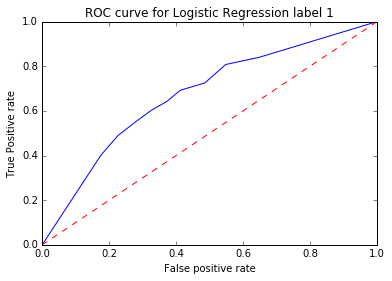

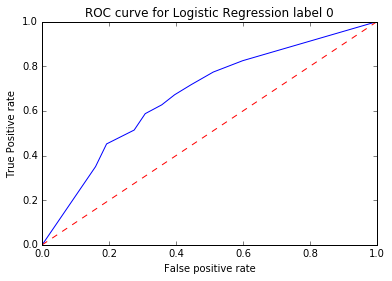

NameError: name 'Best_LOGModel' is not defined

In [103]:
def startTweetSentimentClassification():
    print("stat")
    #NB
    accuracy_nb_train=computeNBTrainAccuracy()
    print("Naive Bayes Classifier Training Accuracy: " + str(accuracy_nb_train * 100)+" %")

    accuracy_nb_test=computeNBTestAccuracy()
    print("Naive Bayes Classifier Test Accuracy " + str(accuracy_nb_test * 100)+" %")
    
    nb_fold_accuracy=crossValidationNB() 
    
    accuracy_nb=computeBestNBTestAccuracy()
    print("Naive Bayes Classifier Test Accuracy of Best Model :" + str(accuracy_nb * 100) +" %")
    
    printNB_Precision_Recall_F1()
     
    aucNB=printNBAreaUnderCurve()
    print("Area Under Curve for LOG: %f" %aucNB)
    
    #LOG
    accuracy_lr_train=computeLOGTrainAccuracy()
    print("Logistic Regression Classifier Training Accuracy: " + str(accuracy_lr_train * 100)+" %")
    
    accuracy_lr_test=computeLOGTestAccuracy()
    print("Logistic Regression Classifier Test Accuracy " + str(accuracy_lr_test * 100)+" %")
 
    log_fold_accuracy=crossValidationLOG()
    
    accuracy_lr=computeBestLOGTestAccuracy()
    print("Logistic Regression Classifier Test Accuracy of Best Model :" + str(accuracy_lr * 100) +" %")
    
    printLOG_Precision_Recall_F1()
     
    aucLOG=printLOGAreaUnderCurve()
    print("Area Under Curve for LOG: %f" %aucLOG)
    
    plotROCCurveLOG()
    
    plotAccuracyGraph(accuracy_nb_test*100,accuracy_nb_train*100,nb_fold_accuracy*100,
                      accuracy_lr_test*100,accuracy_lr_train*100,log_fold_accuracy*100)
   
    #For logistic regression
    printsomeCorrectOrIncorrectTweets()
    printTop5CorrectAndIncorrectTweets()
    
    
    
    #removeSavedModels()

    

In [110]:
startTweetSentimentClassification()

stat
Naive Bayes Classifier Training Accuracy: 82.86125 %
Naive Bayes Classifier Test Accuracy 74.65181058495823 %


Py4JJavaError: An error occurred while calling z:org.apache.spark.mllib.classification.NaiveBayesModel.load.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: file:/home/vishalaxit/vtande2/Best_NBModel/metadata
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:285)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:228)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:313)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:199)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:239)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:237)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:237)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:35)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:239)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:237)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:237)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1307)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1302)
	at org.apache.spark.rdd.RDD$$anonfun$first$1.apply(RDD.scala:1342)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1341)
	at org.apache.spark.mllib.util.Loader$.loadMetadata(modelSaveLoad.scala:129)
	at org.apache.spark.mllib.classification.NaiveBayesModel$.load(NaiveBayes.scala:273)
	at org.apache.spark.mllib.classification.NaiveBayesModel.load(NaiveBayes.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)



########################Printing some test tweets along with their prediction probabilities########################T
1.0 "@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool
0.0 "Reading my kindle2...  Love it... Lee childs is good read."
1.0 "Ok
1.0 "@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)"
1.0 "@mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)"
0.0 "@richardebaker no. it is too big. I'm quite happy with the Kindle2."
1.0 "Fuck this economy. I hate aig and their non loan given asses."
1.0 "Jquery is my new best friend."
1.0 "Loves twitter"
0.0 "how can you not love Obama? he makes jokes about himself."
1.0 "@Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil.  It's a charade and a slogan
0.0 "House Correspondents dinner was last night whoopi
1.0 "Watchin Espn..Jus seen this new Nike Commerical with a Puppet Lebron..sh*t w